In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pandas as pd

In [9]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_mnist = x_test_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0
y_train_cifar = y_train_cifar.flatten()
y_test_cifar = y_test_cifar.flatten()

In [10]:
def create_custom_cnn_mnist():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [11]:
def create_custom_cnn_cifar():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [12]:
split_ratios = [0.6, 0.7, 0.8, 0.9]
results_mnist = []
results_cifar = []
histories_mnist = {}
histories_cifar = {}
models_mnist = {}
models_cifar = {}

In [13]:
print("="*80)
print("TRAINING CUSTOM CNN WITH DIFFERENT TRAIN-TEST SPLITS")
print("="*80)

for split in split_ratios:
    print(f"\n{'='*80}")
    print(f"Training with {int(split*100)}% train - {int((1-split)*100)}% test split")
    print(f"{'='*80}")
    
    train_size = int(len(x_train_mnist) * split)
    x_tr_mnist = x_train_mnist[:train_size]
    y_tr_mnist = y_train_mnist[:train_size]
    x_val_mnist = x_train_mnist[train_size:]
    y_val_mnist = y_train_mnist[train_size:]
    
    y_tr_mnist_cat = keras.utils.to_categorical(y_tr_mnist, 10)
    y_val_mnist_cat = keras.utils.to_categorical(y_val_mnist, 10)
    y_test_mnist_cat = keras.utils.to_categorical(y_test_mnist, 10)
    
    print(f"\nMNIST - Training samples: {len(x_tr_mnist)}, Validation samples: {len(x_val_mnist)}")
    model_mnist = create_custom_cnn_mnist()
    model_mnist.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_mnist = model_mnist.fit(x_tr_mnist, y_tr_mnist_cat, epochs=15, batch_size=128,
                                    validation_data=(x_val_mnist, y_val_mnist_cat), verbose=0)
    test_loss, test_acc = model_mnist.evaluate(x_test_mnist, y_test_mnist_cat, verbose=0)
    
    results_mnist.append({
        'split': f"{int(split*100)}-{int((1-split)*100)}",
        'train_acc': history_mnist.history['accuracy'][-1],
        'val_acc': history_mnist.history['val_accuracy'][-1],
        'test_acc': test_acc
    })
    histories_mnist[split] = history_mnist
    models_mnist[split] = model_mnist
    print(f"MNIST Test Accuracy: {test_acc:.4f}")
    
    train_size = int(len(x_train_cifar) * split)
    x_tr_cifar = x_train_cifar[:train_size]
    y_tr_cifar = y_train_cifar[:train_size]
    x_val_cifar = x_train_cifar[train_size:]
    y_val_cifar = y_train_cifar[train_size:]
    
    y_tr_cifar_cat = keras.utils.to_categorical(y_tr_cifar, 10)
    y_val_cifar_cat = keras.utils.to_categorical(y_val_cifar, 10)
    y_test_cifar_cat = keras.utils.to_categorical(y_test_cifar, 10)
    
    print(f"CIFAR-10 - Training samples: {len(x_tr_cifar)}, Validation samples: {len(x_val_cifar)}")
    model_cifar = create_custom_cnn_cifar()
    model_cifar.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_cifar = model_cifar.fit(x_tr_cifar, y_tr_cifar_cat, epochs=50, batch_size=128,
                                    validation_data=(x_val_cifar, y_val_cifar_cat), verbose=0)
    test_loss, test_acc = model_cifar.evaluate(x_test_cifar, y_test_cifar_cat, verbose=0)
    
    results_cifar.append({
        'split': f"{int(split*100)}-{int((1-split)*100)}",
        'train_acc': history_cifar.history['accuracy'][-1],
        'val_acc': history_cifar.history['val_accuracy'][-1],
        'test_acc': test_acc
    })
    histories_cifar[split] = history_cifar
    models_cifar[split] = model_cifar
    print(f"CIFAR-10 Test Accuracy: {test_acc:.4f}")

df_mnist = pd.DataFrame(results_mnist)
df_cifar = pd.DataFrame(results_cifar)

TRAINING CUSTOM CNN WITH DIFFERENT TRAIN-TEST SPLITS

Training with 60% train - 40% test split

MNIST - Training samples: 36000, Validation samples: 24000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MNIST Test Accuracy: 0.9906
CIFAR-10 - Training samples: 30000, Validation samples: 20000
CIFAR-10 Test Accuracy: 0.8376

Training with 70% train - 30% test split

MNIST - Training samples: 42000, Validation samples: 18000
MNIST Test Accuracy: 0.9908
CIFAR-10 - Training samples: 35000, Validation samples: 15000
CIFAR-10 Test Accuracy: 0.8455

Training with 80% train - 19% test split

MNIST - Training samples: 48000, Validation samples: 12000
MNIST Test Accuracy: 0.9913
CIFAR-10 - Training samples: 40000, Validation samples: 10000
CIFAR-10 Test Accuracy: 0.8508

Training with 90% train - 9% test split

MNIST - Training samples: 54000, Validation samples: 6000
MNIST Test Accuracy: 0.9926
CIFAR-10 - Training samples: 45000, Validation samples: 5000
CIFAR-10 Test Accuracy: 0.8606



MNIST RESULTS - DIFFERENT TRAIN-TEST SPLITS
split  train_acc  val_acc  test_acc
60-40   0.992556 0.988833    0.9906
70-30   0.993095 0.989556    0.9908
80-19   0.993479 0.991917    0.9913
 90-9   0.993926 0.992167    0.9926

CIFAR-10 RESULTS - DIFFERENT TRAIN-TEST SPLITS
split  train_acc  val_acc  test_acc
60-40     0.9366  0.83875    0.8376
70-30     0.9358  0.84760    0.8455
80-19     0.9370  0.85600    0.8508
 90-9     0.9370  0.86940    0.8606


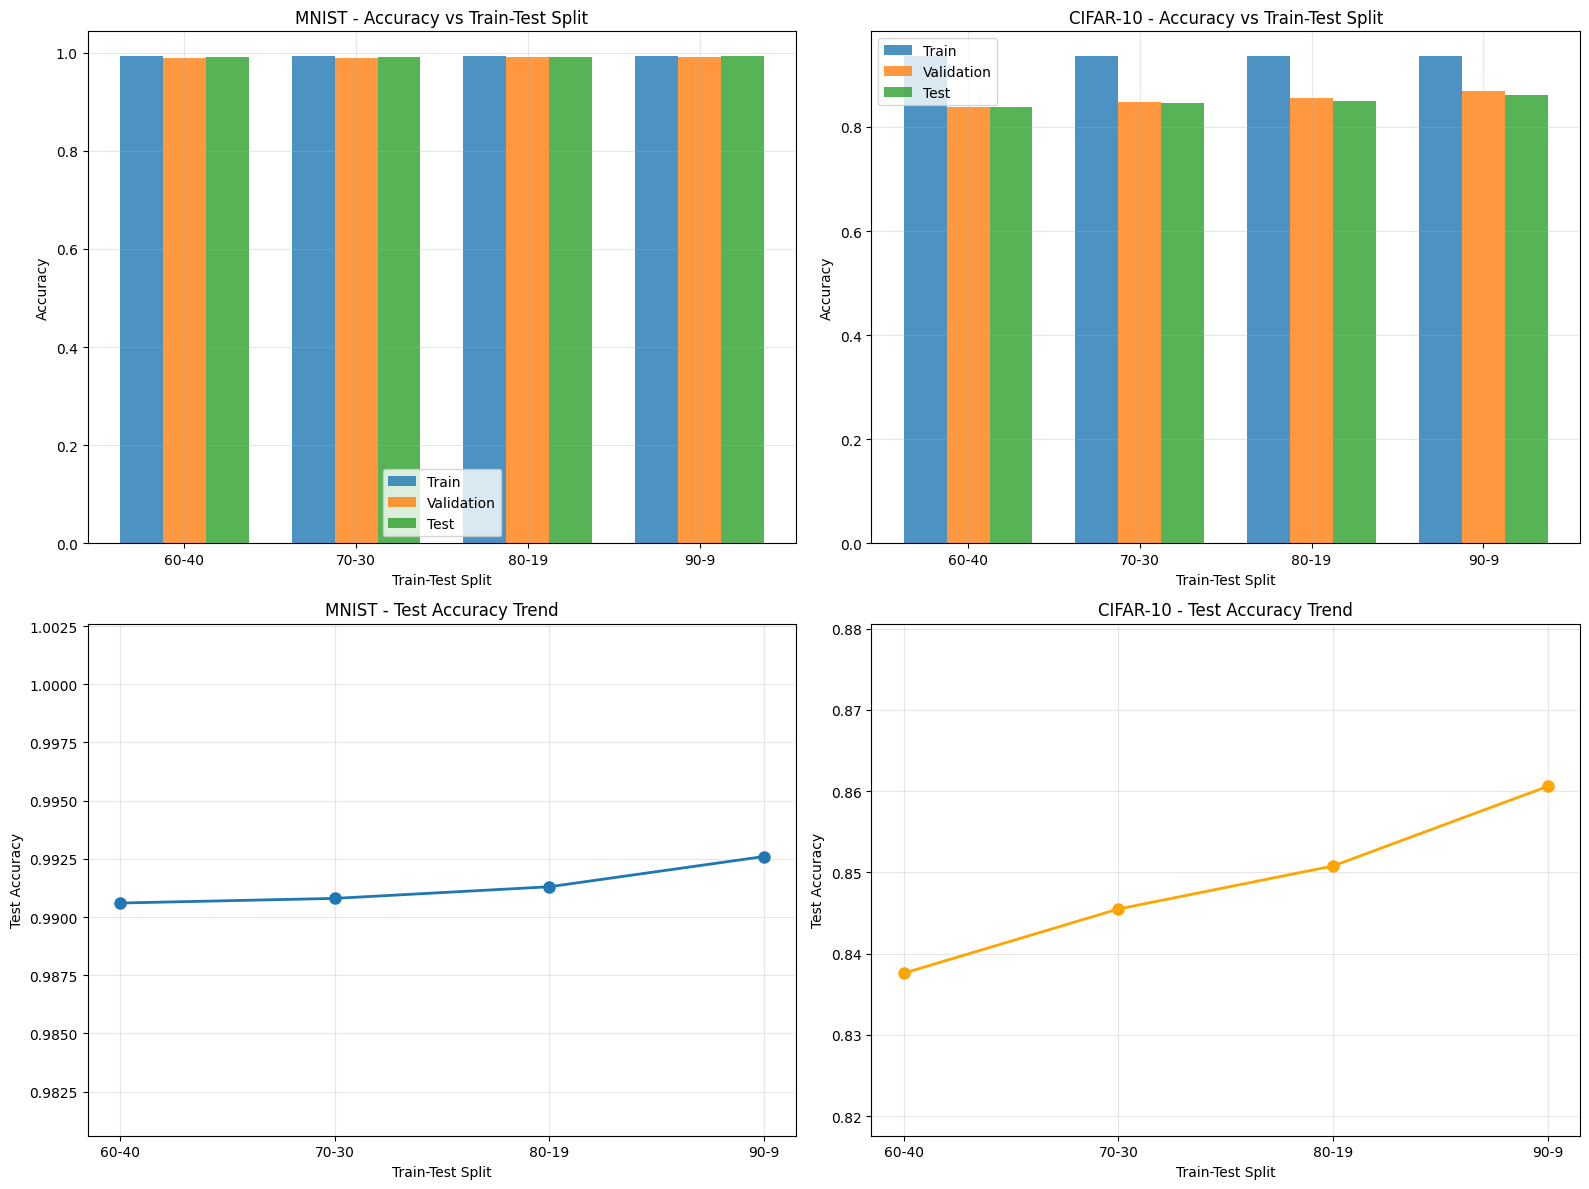


Best split for MNIST: 90-9
Best split for CIFAR-10: 90-9


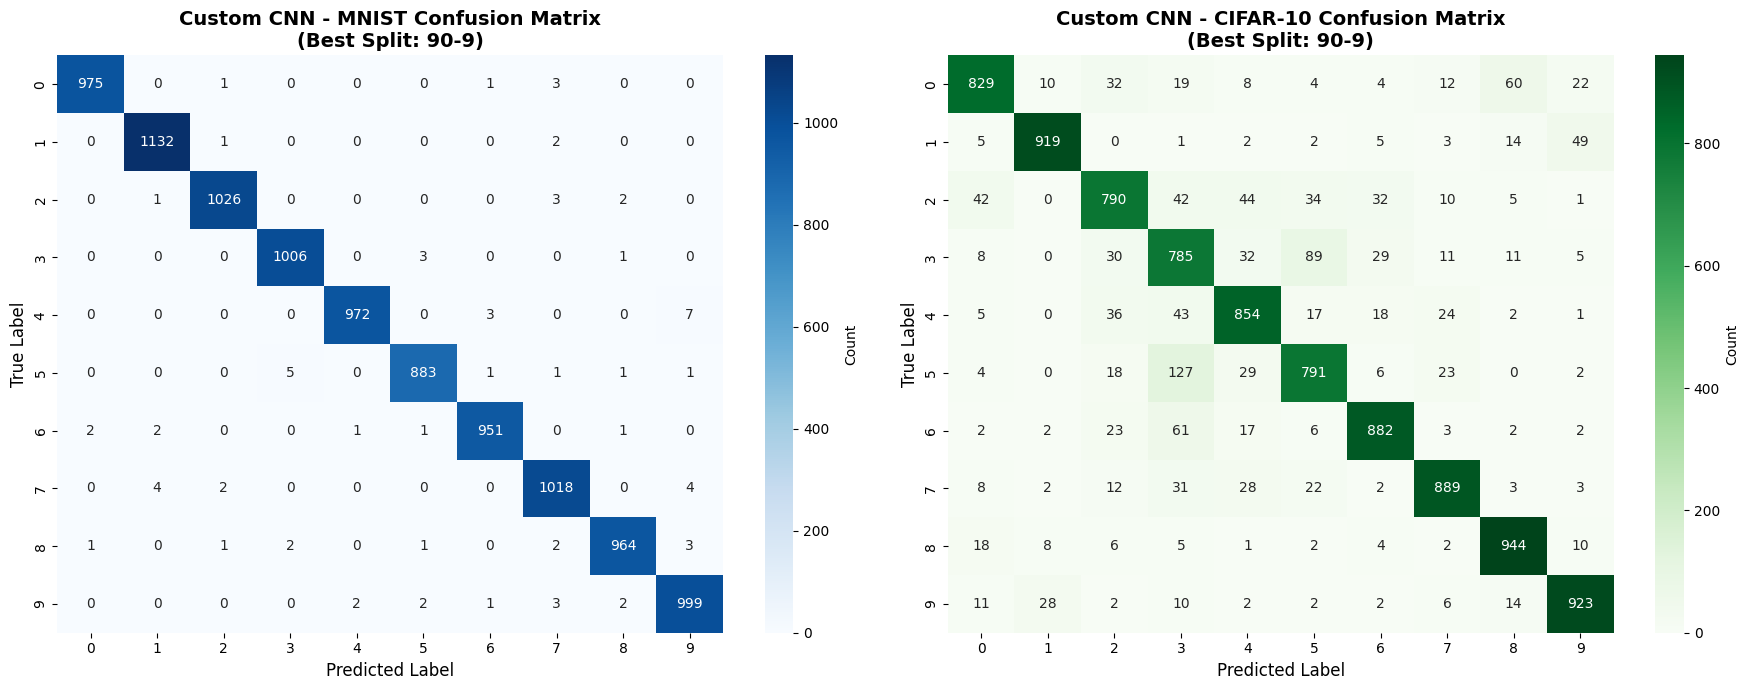

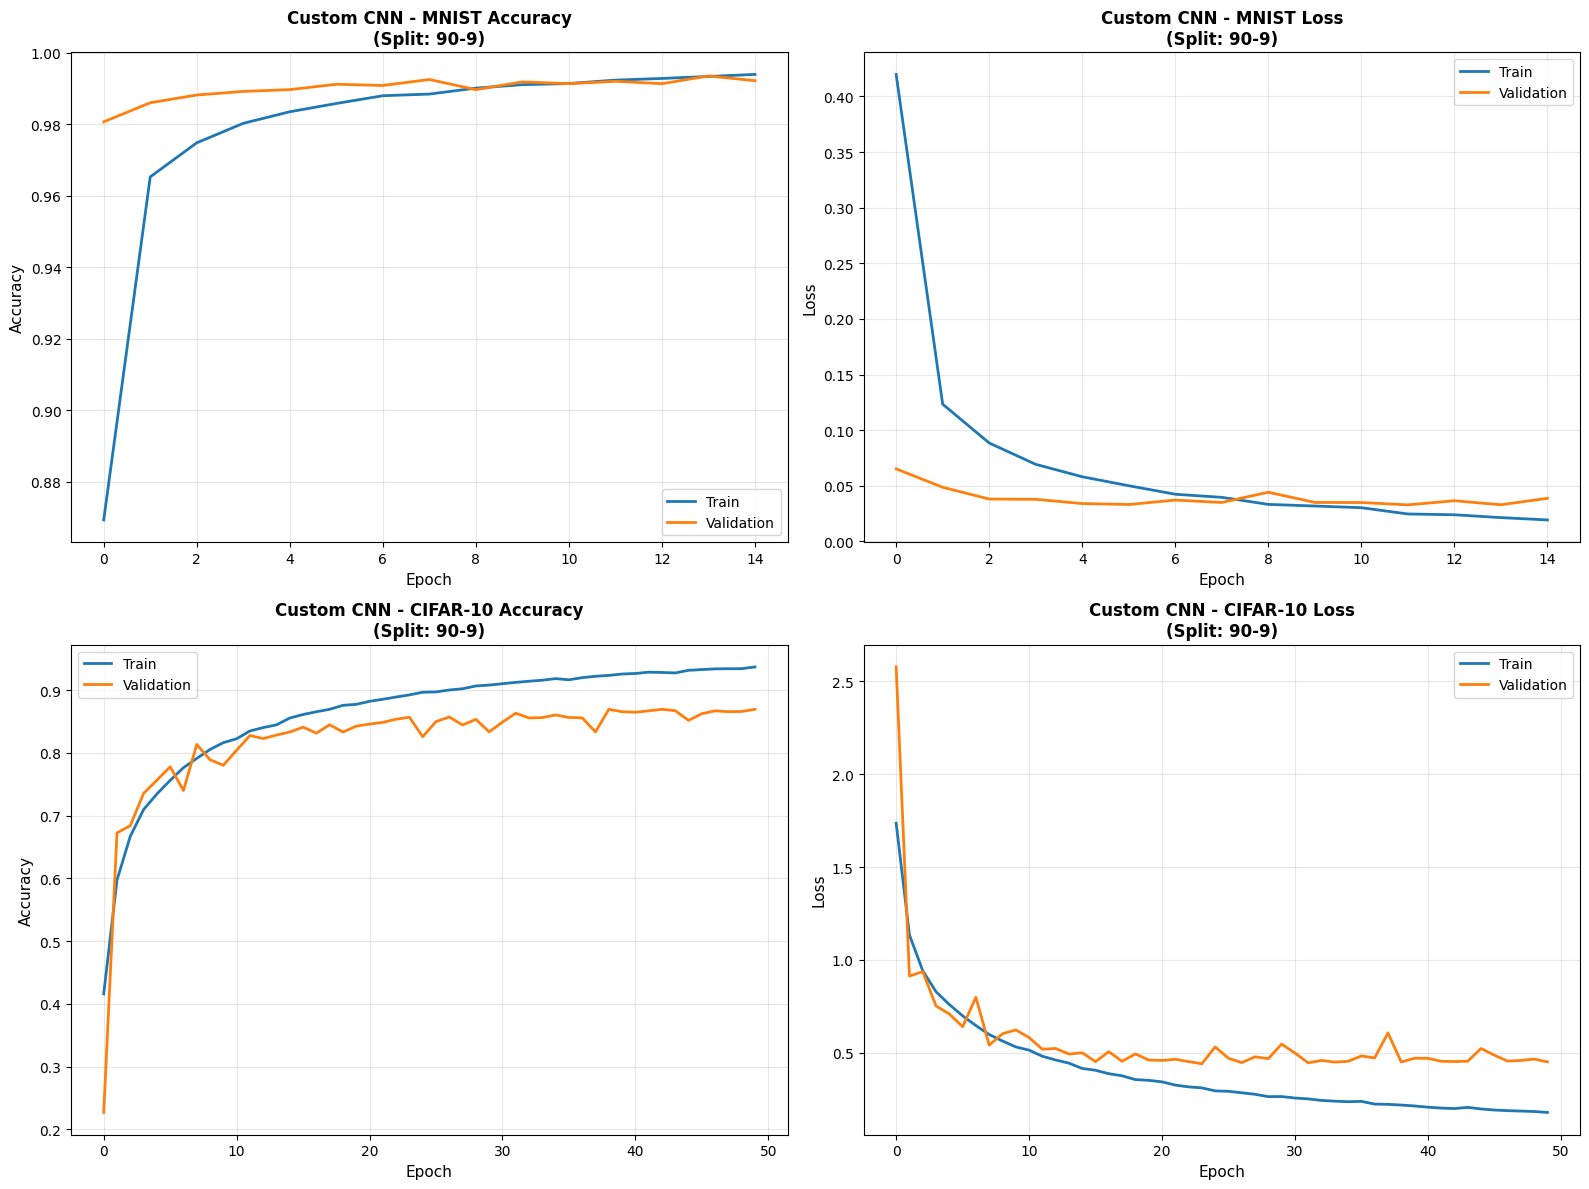

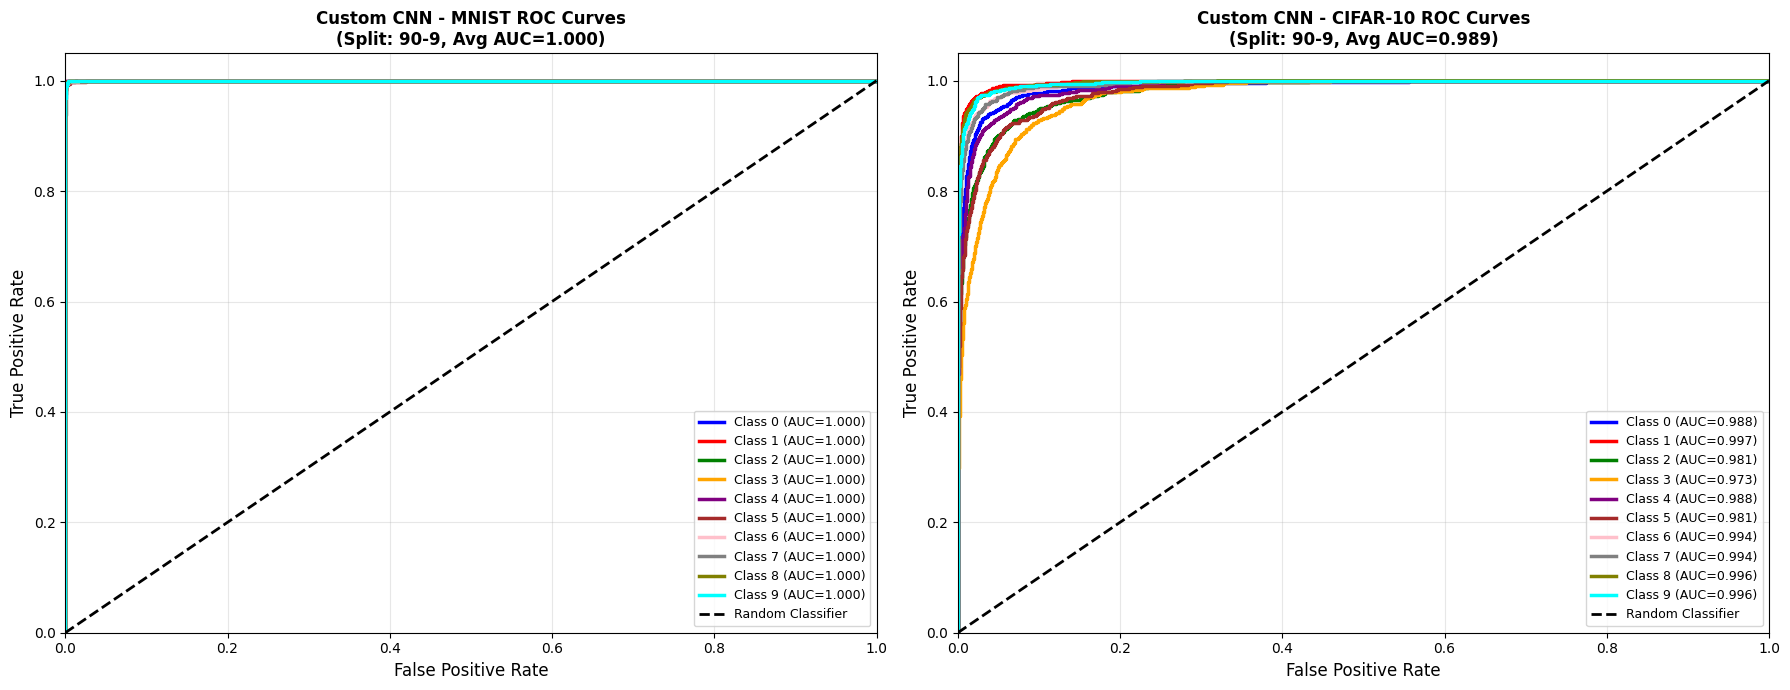


CUSTOM CNN - BEST CASE RESULTS SUMMARY

MNIST (Best Split: 90-9)
  Test Accuracy: 0.9926
  Average AUC: 0.9999

CIFAR-10 (Best Split: 90-9)
  Test Accuracy: 0.8606
  Average AUC: 0.9887


In [14]:
print("\n" + "="*80)
print("MNIST RESULTS - DIFFERENT TRAIN-TEST SPLITS")
print("="*80)
print(df_mnist.to_string(index=False))

print("\n" + "="*80)
print("CIFAR-10 RESULTS - DIFFERENT TRAIN-TEST SPLITS")
print("="*80)
print(df_cifar.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

splits_labels = [f"{int(s*100)}-{int((1-s)*100)}" for s in split_ratios]
mnist_train_accs = [r['train_acc'] for r in results_mnist]
mnist_val_accs = [r['val_acc'] for r in results_mnist]
mnist_test_accs = [r['test_acc'] for r in results_mnist]

x_pos = np.arange(len(splits_labels))
width = 0.25

axes[0, 0].bar(x_pos - width, mnist_train_accs, width, label='Train', alpha=0.8)
axes[0, 0].bar(x_pos, mnist_val_accs, width, label='Validation', alpha=0.8)
axes[0, 0].bar(x_pos + width, mnist_test_accs, width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Train-Test Split')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('MNIST - Accuracy vs Train-Test Split')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(splits_labels)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

cifar_train_accs = [r['train_acc'] for r in results_cifar]
cifar_val_accs = [r['val_acc'] for r in results_cifar]
cifar_test_accs = [r['test_acc'] for r in results_cifar]

axes[0, 1].bar(x_pos - width, cifar_train_accs, width, label='Train', alpha=0.8)
axes[0, 1].bar(x_pos, cifar_val_accs, width, label='Validation', alpha=0.8)
axes[0, 1].bar(x_pos + width, cifar_test_accs, width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Train-Test Split')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('CIFAR-10 - Accuracy vs Train-Test Split')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(splits_labels)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(splits_labels, mnist_test_accs, marker='o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Train-Test Split')
axes[1, 0].set_ylabel('Test Accuracy')
axes[1, 0].set_title('MNIST - Test Accuracy Trend')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([min(mnist_test_accs)-0.01, max(mnist_test_accs)+0.01])

axes[1, 1].plot(splits_labels, cifar_test_accs, marker='o', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('Train-Test Split')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].set_title('CIFAR-10 - Test Accuracy Trend')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([min(cifar_test_accs)-0.02, max(cifar_test_accs)+0.02])

plt.tight_layout()
plt.savefig('cnn_split_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

best_split_mnist = split_ratios[np.argmax([r['test_acc'] for r in results_mnist])]
best_split_cifar = split_ratios[np.argmax([r['test_acc'] for r in results_cifar])]

print(f"\nBest split for MNIST: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)}")
print(f"Best split for CIFAR-10: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)}")

best_model_mnist = models_mnist[best_split_mnist]
best_model_cifar = models_cifar[best_split_cifar]
best_history_mnist = histories_mnist[best_split_mnist]
best_history_cifar = histories_cifar[best_split_cifar]

y_test_mnist_cat = keras.utils.to_categorical(y_test_mnist, 10)
y_test_cifar_cat = keras.utils.to_categorical(y_test_cifar, 10)

y_pred_mnist = best_model_mnist.predict(x_test_mnist, verbose=0)
y_pred_mnist_classes = np.argmax(y_pred_mnist, axis=1)

y_pred_cifar = best_model_cifar.predict(x_test_cifar, verbose=0)
y_pred_cifar_classes = np.argmax(y_pred_cifar, axis=1)

cm_mnist = confusion_matrix(y_test_mnist, y_pred_mnist_classes)
cm_cifar = confusion_matrix(y_test_cifar, y_pred_cifar_classes)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(cm_mnist, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Custom CNN - MNIST Confusion Matrix\n(Best Split: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

sns.heatmap(cm_cifar, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Custom CNN - CIFAR-10 Confusion Matrix\n(Best Split: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)})', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('cnn_confusion_matrices_best.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(best_history_mnist.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(best_history_mnist.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title(f'Custom CNN - MNIST Accuracy\n(Split: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)})', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(best_history_mnist.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(best_history_mnist.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title(f'Custom CNN - MNIST Loss\n(Split: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(best_history_cifar.history['accuracy'], label='Train', linewidth=2)
axes[1, 0].plot(best_history_cifar.history['val_accuracy'], label='Validation', linewidth=2)
axes[1, 0].set_title(f'Custom CNN - CIFAR-10 Accuracy\n(Split: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(best_history_cifar.history['loss'], label='Train', linewidth=2)
axes[1, 1].plot(best_history_cifar.history['val_loss'], label='Validation', linewidth=2)
axes[1, 1].set_title(f'Custom CNN - CIFAR-10 Loss\n(Split: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_loss_curves_best.png', dpi=300, bbox_inches='tight')
plt.show()

y_test_mnist_bin = label_binarize(y_test_mnist, classes=range(10))
y_test_cifar_bin = label_binarize(y_test_cifar, classes=range(10))

fpr_mnist = {}
tpr_mnist = {}
roc_auc_mnist = {}
for i in range(10):
    fpr_mnist[i], tpr_mnist[i], _ = roc_curve(y_test_mnist_bin[:, i], y_pred_mnist[:, i])
    roc_auc_mnist[i] = auc(fpr_mnist[i], tpr_mnist[i])

fpr_cifar = {}
tpr_cifar = {}
roc_auc_cifar = {}
for i in range(10):
    fpr_cifar[i], tpr_cifar[i], _ = roc_curve(y_test_cifar_bin[:, i], y_pred_cifar[:, i])
    roc_auc_cifar[i] = auc(fpr_cifar[i], tpr_cifar[i])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(10), colors):
    axes[0].plot(fpr_mnist[i], tpr_mnist[i], color=color, lw=2.5,
                 label=f'Class {i} (AUC={roc_auc_mnist[i]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'Custom CNN - MNIST ROC Curves\n(Split: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)}, Avg AUC={np.mean(list(roc_auc_mnist.values())):.3f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(True, alpha=0.3)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(10), colors):
    axes[1].plot(fpr_cifar[i], tpr_cifar[i], color=color, lw=2.5,
                 label=f'Class {i} (AUC={roc_auc_cifar[i]:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'Custom CNN - CIFAR-10 ROC Curves\n(Split: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)}, Avg AUC={np.mean(list(roc_auc_cifar.values())):.3f})', 
                  fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_roc_auc_curves_best.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("CUSTOM CNN - BEST CASE RESULTS SUMMARY")
print("="*80)
print(f"\nMNIST (Best Split: {int(best_split_mnist*100)}-{int((1-best_split_mnist)*100)})")
print(f"  Test Accuracy: {results_mnist[split_ratios.index(best_split_mnist)]['test_acc']:.4f}")
print(f"  Average AUC: {np.mean(list(roc_auc_mnist.values())):.4f}")
print(f"\nCIFAR-10 (Best Split: {int(best_split_cifar*100)}-{int((1-best_split_cifar)*100)})")
print(f"  Test Accuracy: {results_cifar[split_ratios.index(best_split_cifar)]['test_acc']:.4f}")
print(f"  Average AUC: {np.mean(list(roc_auc_cifar.values())):.4f}")
print("="*80)